In [1]:
# Bibliotecas
import pandas as pd
from pandas import json_normalize
import numpy as np
import io
import requests
import json
import datetime
import scipy.stats as stats
from datetime import datetime
import time

import os

#from google.cloud import bigquery
#from google.oauth2 import service_account
#import pandas_gbq
import pyarrow

import matplotlib.pyplot as plt
import seaborn           as sns

#import fathon
#from numpy.matlib import repmat
#from fathon import fathonUtils as fu

In [30]:
class agro:
    
    def __init__(self, tickers: "list of tickers", init_date: "initial date",
                 end_date: "end date", freq_time: str, index: int, climate_var: str,
                 state: str):
        # Inicialmente passo as variáveis para uma self.
        self.tickers = tickers # lista com os nomes das ações
        self.init_date = init_date
        self.freq_time = freq_time
        self.end_date = end_date
        self.index = index # índice que será usado
        self.climate_var = climate_var
        self.state = state
        
    def plot_agro(self):

        clima = pd.read_parquet('.\\raw_data\\clima_Agro.parquet', engine='pyarrow')
        clima = clima.drop_duplicates(['Date', 'RegionID'])
        clima.reset_index(drop = True, inplace = True)
        clima = clima.rename(columns={'Date': 'time'})
        clima = clima.rename(columns={'RegionID': 'CD_MUN'})
        clima['time'] = pd.to_datetime(clima['time'], format='%Y-%m-%d')
        
        depara = pd.read_csv('.\\raw_data\\de_para_IBGE.csv')
        depara['CD_MUN'] = depara['CD_MUN'].astype(str)
        
        #clima = clima[['time', self.climate_var]]
        
        clima = pd.merge(clima, depara, on='CD_MUN', how='left')
        
        clima['total_precipitation'] = clima['total_precipitation'].astype(float)
        clima = clima[clima.SIGLA_UF == self.state]
        
        clima = clima.groupby(['SIGLA_UF', 'time']).agg(media = (self.climate_var, 'mean'))
        clima.reset_index(drop = False, inplace = True)
        clima = clima.rename(columns={'media': self.climate_var})
        

        names = pd.read_csv('.\\raw_data\\portfolio.csv') # ler o arquivo em csv
        names = pd.Series(names.stock_id.values,index=names.ticker).to_dict()

        cod = []
        for i in self.tickers:
            i = '$'+i
            cod.append([value for key, value in names.items() if key == i][0])

        url = ('https://stocks.tradersclub.com.br/stockschart/v1/history_quotes?stock='
               + str(cod[0]) +'&group='+ self.freq_time + 
               '&start='+ self.init_date + '&end=' + self.end_date)

        #return print(url)

        # credenciais de acesso a API
        headers = {"Authorization": f"ml_prod:4a1fc619-1993-42f3-adf4-123c0a72b3ee"}

        response = requests.request(
                            "GET", 
                            url,
                            headers=headers)

        # O request tem como saída um dicionário
        json_dict= json.loads(response.text)

        # Aqui trasformo o dicionário em um pandas Dataframe
        ticker = pd.DataFrame.from_dict(json_dict["Quotes"])

        # Pego apenas duas colunas. A coluna de time com a data e coulna do índice de interesse.
        cols_to_keep = ['time', self.index]
        ticker = ticker[cols_to_keep]
        # renomeio a coluna colocando o nome da ação como sufixo
        ticker = ticker.rename(columns={self.index: self.tickers[0]})
        ticker['time'] = pd.to_datetime(ticker['time'], format='%Y-%m-%d', utc=True)
        ticker['time'] = ticker['time'].dt.strftime('%Y-%m-%d')
        ticker['time'] = pd.to_datetime(ticker['time'], format='%Y-%m-%d')
        
        full = pd.merge(ticker, clima, on='time', how='left')
        
        full[self.tickers[0]] = full[self.tickers[0]].shift(5)
        
        from sklearn.preprocessing import MinMaxScaler
        full[self.tickers[0]] = MinMaxScaler().fit_transform(np.array(full[self.tickers[0]]).reshape(-1,1))
        full[self.climate_var] = MinMaxScaler().fit_transform(np.array(full[self.climate_var]).reshape(-1,1))

        return full
    

In [ ]:
ag = agro(tickers = ['PETR4'], 
                     init_date = '2019-01-01', # '%Y-%m-%d'
                     end_date = '2020-12-31', # '%Y-%m-%d'
                     freq_time = '1d', # 1m, 5m, 15m, 30m, 1h, 1d, 1w, 30d
                     index = 'Close',
                     climate_var = 'total_precipitation',
                     state = 'SP'
         ) # Low, High, Open e Close
df = ag.plot_agro()

In [ ]:
df.head(39)

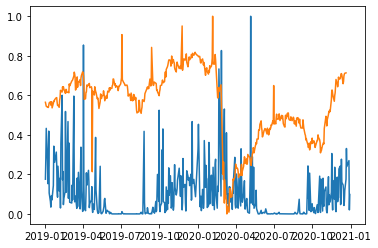

In [173]:
plt.plot(df.time, df.total_precipitation, df.time, df.PETR4)
plt.show()

In [175]:
len(df)

497

In [179]:
clima = pd.read_parquet('.\\raw_data\\clima_Agro.parquet', engine='pyarrow')
#clima = clima.drop_duplicates(['Date'])
#clima.reset_index(drop = True, inplace = True)
#clima = clima.rename(columns={'Date': 'time'})
#clima['time'] = pd.to_datetime(clima['time'], format='%Y-%m-%d')
        
#clima = clima[['time', self.climate_var]]

In [180]:
len(clima)

4071670

In [181]:
clima.head(3)

,Date,RegionID,dewpoint_temperature_2m,max_temperature_2m,min_temperature_2m,temperature_2m,humidity,surface_pressure,total_precipitation,u_component_of_wind_10m,v_component_of_wind_10m
0,2019-01-01,1100130,296.36707863443314,302.49098364526117,295.08589025029346,297.8721410270602,91.35385607173502,99597.0182225474,0.09543030610766196,-0.2394271555568101,-0.5080213875124306
1,2019-01-01,1100205,296.6726113961178,302.00172638040584,295.93045275903546,298.0167326973315,92.25408195647613,99777.73470278824,0.10654724487368478,-0.09217174953431655,-0.5229376537895981
2,2019-01-01,1100403,296.4707929418539,302.12087764058793,295.88730202581667,297.91544719894324,91.69041662372214,99600.77291905036,0.06959664951961031,-0.13135332280259074,-0.5357115927300603


In [2]:
ls

 O volume na unidade C é OS
 O Número de Série do Volume é DAF4-E719

 Pasta de C:\Users\aureliano.paiva_tc\Documents\GitHub\Clima_Agro

23/03/2022  07:10    <DIR>          .
23/03/2022  07:10    <DIR>          ..
22/03/2022  16:08               379 .gitignore
22/03/2022  16:06    <DIR>          .ipynb_checkpoints
23/03/2022  07:10            60.455 Clima_Agro.ipynb
20/03/2022  09:14             1.094 LICENSE
23/03/2022  09:16    <DIR>          raw_data
20/03/2022  09:14                12 README.md
22/03/2022  16:29            12.567 transform_csv_to_parquet.ipynb
               5 arquivo(s)         74.507 bytes
               4 pasta(s)   119.768.215.552 bytes disponíveis


In [20]:
clima = pd.read_parquet('.\\raw_data\\clima_Agro.parquet', engine='pyarrow')
clima = clima.drop_duplicates(['Date', 'RegionID'])
clima.reset_index(drop = True, inplace = True)
clima = clima.rename(columns={'Date': 'time'})
clima = clima.rename(columns={'RegionID': 'CD_MUN'})
clima['time'] = pd.to_datetime(clima['time'], format='%Y-%m-%d')
        
depara = pd.read_csv('.\\raw_data\\de_para_IBGE.csv')
depara['CD_MUN'] = depara['CD_MUN'].astype(str)

In [21]:
clima = pd.merge(clima, depara, on='CD_MUN', how='left')

In [24]:
clima.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4071670 entries, 0 to 4071669
Data columns (total 13 columns):
 #   Column                   Dtype         
---  ------                   -----         
 0   time                     datetime64[ns]
 1   CD_MUN                   object        
 2   dewpoint_temperature_2m  object        
 3   max_temperature_2m       object        
 4   min_temperature_2m       object        
 5   temperature_2m           object        
 6   humidity                 object        
 7   surface_pressure         object        
 8   total_precipitation      object        
 9   u_component_of_wind_10m  object        
 10  v_component_of_wind_10m  object        
 11  NM_MUN                   object        
 12  SIGLA_UF                 object        
dtypes: datetime64[ns](1), object(12)
memory usage: 434.9+ MB


In [28]:
#clima = clima[['time', self.climate_var]]
        

#clima['total_precipitation'] = clima['total_precipitation'].astype(float)        
#clima = clima[clima.SIGLA_UF == 'SP']
        
clima2 = clima.groupby(['SIGLA_UF', 'time']).agg(media = ('total_precipitation', 'mean'))
clima2.reset_index(drop = False, inplace = True)
clima2 = clima2.rename(columns={'media': 'total_precipitation'})

In [29]:
clima2

,SIGLA_UF,time,total_precipitation
0,SP,2019-01-01,0.014798
1,SP,2019-01-02,0.022551
2,SP,2019-01-03,0.023090
3,SP,2019-01-04,0.101788
4,SP,2019-01-05,0.311368
...,...,...,...
726,SP,2020-12-27,0.108358
727,SP,2020-12-28,0.164435
728,SP,2020-12-29,0.062261
729,SP,2020-12-30,0.068421
